[View in Colaboratory](https://colab.research.google.com/github/dattarajrao/PredixDeepLearning/blob/master/TensorFlow_CPU_vs_GPU_vs_TPU_timings_CIFAR_dataset.ipynb)


## This is a test Colab Notebook for evaluating performance of a Convolutional Neural Network (CNN) model for Image Classification on 3 different types of hardware - NVIDIA GPU, Google TPU, Regular CPU

This is not exactly a detailed comparison because the GPU and TPU specs keep changing with new enhancements. By changing runtime in Google Colab you can see how the code works with each hardware.

**Author: Dattaraj Rao (dattarajrao@yahoo.com)**

![CIFAR demo on Colaboratory](https://s3.ap-south-1.amazonaws.com/dattaraj-public/cifar1.gif)

## Import libraries and check if Cloud runtime has a GPU, TPU or only CPU

In [17]:
import tensorflow as tf
import os

# Check if GPU exists
gpu_exists = (tf.test.gpu_device_name() != '')
# Check if TPU exists
tpu_exists = (os.getenv('COLAB_TPU_ADDR') is not None)

if gpu_exists:
  print('GPU device found: ', tf.test.gpu_device_name())
elif tpu_exists:
  print('TPU device found: ', os.getenv('COLAB_TPU_ADDR'))
else:
  print('No GPU or TPU. We have to reply on good old CPU!')

print ('----------------')
print ()
print ()  
print('---------- CPU configuration --- START ----------')
command = 'cat /proc/cpuinfo'
print (os.popen(command).read().strip())
print('---------- CPU configuration --- END ----------')

print('---------- Memory configuration --- START ----------')
command = 'cat /proc/meminfo'
print (os.popen(command).read().strip())
print('---------- Memory configuration --- END ----------')

TPU device found:  10.34.125.18:8470
----------------


---------- CPU configuration --- START ----------
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm pti ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms xsaveopt arat arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical,

## Load the CIFAR-10 Dataset in memory

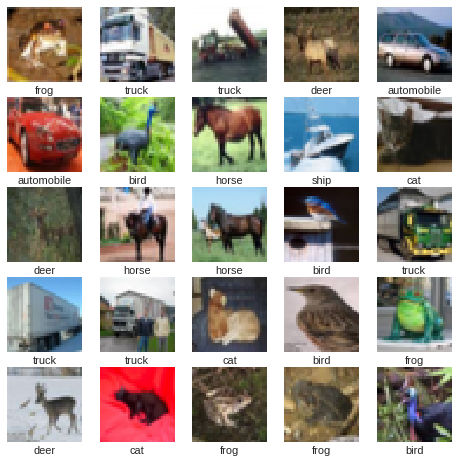

In [18]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

dataset = keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = dataset.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])

x_train, x_test = train_images / 255.0, test_images / 255.0
y_train, y_test = train_labels, test_labels

## Build the Convolutional Neural Network Model

In [19]:
model = tf.keras.models.Sequential([
    
  tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Conv2D(64, (3, 3)),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_7 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        36928     
__________

## Train the Model and record Training Time

In [20]:
import datetime

# start training
st_time = datetime.datetime.now()

num_epochs = 10

if not tpu_exists:
  model.fit(x_train, y_train, epochs=num_epochs)

else:
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(
      model,
      strategy=tf.contrib.tpu.TPUDistributionStrategy(
          tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
      )
  )
  tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
      loss=tf.keras.losses.sparse_categorical_crossentropy,
      metrics=['sparse_categorical_accuracy']
  )

  def train_gen(batch_size):
    while True:
      offset = np.random.randint(0, x_train.shape[0] - batch_size)
      yield x_train[offset:offset+batch_size], y_train[offset:offset + batch_size]


  tpu_model.fit_generator(
      train_gen(1024),
      epochs=num_epochs,
      steps_per_epoch=100,
      validation_data=(x_test, y_test),
  )
  
# record time after training
end_time = datetime.datetime.now()

print('Training time = %s'%(end_time-st_time))

#model.evaluate(x_test, y_test)

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.34.125.18:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 13788712280527167724)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 13085170975556843192)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 10650371553586509049)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 11739925444079134003)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 9653420500203444440)
INFO:tensorflow:*** Available Device: _Devi

## Run Inference (Prediction) - Record time taken

In [21]:
# start inference - for 1000 tests
st_time = datetime.datetime.now()

if not tpu_exists:
  newmodel = model
else:
  newmodel = tpu_model

index = 0
myfig = [18,5]
maxrow = 15
plt.figure(figsize=myfig)
for count in range(10000):
  prediction = newmodel.predict(np.expand_dims(x_test[count], axis=0))
  # show every 10th value
  imgtitle = "%s"%(class_names[np.argmax(prediction)])
  plt.subplot(1,maxrow,index+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_test[count], animated=True)
  plt.xlabel(imgtitle)
  index += 1
  if index == maxrow:
    plt.show()
    plt.figure(figsize=myfig)
    index = 0
  
# record time after inference
end_time = datetime.datetime.now()

print('Inference time = %s'%(end_time-st_time))
print ('Predicted/Actual')

AssertionError: ignored